# I. Introduction 
    Movie recommendation is a very common and widely used technique among all different media platforms. Anime represents a unique group of the community and it has its own culture with a different user distribution compared to that of regular movies.  It is very interesting to analyze the information from the anime community and build a recommendation system for its own specialty. In this work, I implemented a Data-Driven Recommendation Model on anime datasets.

In [2]:
# Import Package
import pandas as pd
import os
import numpy as np
import glob
from sklearn.utils import shuffle
import seaborn as sns 
from sklearn.metrics import jaccard_similarity_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import manhattan_distances
from scipy.sparse.linalg import svds


# II. Dataset 

The datasets I used in this work were downloaded from  [Kaggle](https://www.kaggle.com/azathoth42/myanimelist). The original data were collected from the website known as MyAnimeList.net which is an anime and manga social networking and social cataloging application website. This dataset aims to be representative sample of internet otaku community for demographics analysis and trends inside this group. It contains information about users’ gender, location, birth date, as well as the anime’s airing date, genres, producer and the relationship between users and anime. 

In [3]:
obs =os.path.dirname(os.getcwd()) 
Datpath= obs + "\\Data\\"
Output = obs + "\\output\\"
Dataset = list(glob.glob(Datpath + "*.csv" ))

# read  the datasets
Anime= pd.read_csv(Dataset[0])
User= pd.read_csv(Dataset[5])
UserAnime= pd.read_csv(Dataset[3])

In [4]:
print("Before: The shape of Anime",Anime.shape)
print("Before: The shape of User ",User.shape)
print("Before: The shape of UserAnime",UserAnime.shape)

Before: The shape of Anime (14478, 31)
Before: The shape of User  (108711, 17)
Before: The shape of UserAnime (80076112, 11)


# III. Data Preprocessing

#### Anime Datasets

    In the anime dataset, I dropped the non-significant features such as Japanese title, title_synonyms,image_url,opening theme, and ending theme etc., which are not applicable to this work. I also dropped the anime not yet aired as any rating scores would cause inaccuracy. 

In [5]:
Anime=Anime[Anime["status"]!="Not yet aired"]
Anime=Anime[['anime_id', 'title','source','studio', 'genre','episodes','rating',
             'score', 'scored_by', 'rank', 'popularity','producer']]
print("Cleaned: The shape of Anime",Anime.shape)
print("\n show Anime dataset: \n")
shuffle(Anime).head(10)

Cleaned: The shape of Anime (14142, 12)

 show Anime dataset: 



,anime_id,title,source,studio,genre,episodes,rating,score,scored_by,rank,popularity,producer
3207,3655,Nabari no Ou,Manga,J.C.Staff,"Action, Fantasy, Supernatural, Comedy, Drama, ...",26,PG-13 - Teens 13 or older,7.40,50069,2031.0,681,"Square Enix, Kinyosha"
368,31073,Show By Rock!!: Plasmagica na Gogo,Game,NaN,Comedy,3,G - All Ages,5.85,194,7701.0,8364,Sanrio
2617,9861,Anime Tenchou Movie,Unknown,NaN,"Action, Parody",1,G - All Ages,5.54,365,8289.0,7387,NaN
7103,23523,Aterui,Unknown,NaN,"Action, Fantasy, Historical",1,G - All Ages,5.73,11,9656.0,11535,Cinema Tohoku
1885,31068,Hime Chen! Otogi Chikku Idol Lilpri (2011),Unknown,Telecom Animation Film,"Magic, Shoujo",51,PG - Children,6.87,224,4039.0,8664,Shogakukan Music &amp; Digital Entertainment
789,19569,Junjou Shoujo Et Cetera,Manga,Studio 1st,Hentai,2,Rx - Hentai,6.78,1165,NaN,5704,Pashmina
9334,37287,Tsuma Netori: Ryoujoku Rinne,Visual novel,NaN,Hentai,0,Rx - Hentai,6.53,173,NaN,9184,ZIZ Entertainment (ZIZ)
4311,23737,Neko Pitcher,4-koma manga,NaN,"Comedy, Sports, Kids",51,G - All Ages,7.04,24,11439.0,10055,NaN
13703,7980,Shin Obake no Q-tarou,Unknown,NaN,"Comedy, School, Slice of Life, Supernatural",70,G - All Ages,5.71,38,12072.0,11342,NaN
6367,2570,Ochame na Futago: Claire Gakuin Monogatari,Novel,TMS Entertainment,"Kids, Slice of Life, Comedy, Historical, Schoo...",26,G - All Ages,7.12,654,3135.0,7405,Tokyo Movie Shinsha


#### Users Dataset

<ol>
  <p>For user dataset, I used cleaned version in this work. It ignore the users with wrong information. For example, the users whose last online date was before their joined date. The users who watched incredibly huge amount of anime episodes (over 100 million) that likely is not true. Users who watched more episodes than the given anime produced. The users with information that last online time earlier than 1950 (simply impossible) and the users younger than 5 and older than 90.</p>
  <li>I filter out the user having mean score=0 and whose spent watching days less than 1. I also dropped the non-significant features such as location, access_rank,join_date,last_online,stats_rewatched,stats_episodes etc, which are not applicable to this work.</li>
    
  <li>I used "birth_date" feature to change it to "Age", it transfer the datetime datatype to int and make it easier for further analysis..</li>
<ol>

    
    

In [6]:
User = User[User["stats_mean_score"]!=0 & User["stats_mean_score"].notnull()]
User = User[User["user_days_spent_watching"]> 1]
User['age'] = User['birth_date'].apply(lambda row: (2018-int(row.split(sep= "-")[0])))
User=User.drop(["user_onhold","user_dropped","user_plantowatch","access_rank","join_date","last_online","stats_rewatched","stats_episodes","location","birth_date"],axis=1)
User=User.reset_index(drop=True)
User['username']=User['username'].apply(str)
print("The shape of User ",User.shape)
print("\n show User dataset: \n")
shuffle(User).head(10)

The shape of User  (105403, 8)

 show User dataset: 



,username,user_id,user_watching,user_completed,user_days_spent_watching,gender,stats_mean_score,age
67435,ikkakuju,2002102,14,52,25.364931,Female,8.00,25
76145,FantasticHarmony,5044590,36,138,78.286111,Female,9.28,21
15538,Hong-Sul,347079,3,347,74.550000,Female,7.48,27
45702,sunnybricks,870741,13,31,33.555556,Female,8.85,24
1403,RintoKu,116703,6,437,70.377083,Female,6.85,23
89015,Benji13,239188,11,261,112.421528,Male,7.47,24
59879,irenesky,4161415,20,284,79.948958,Female,9.00,22
72812,Axalon0,357796,9,322,107.710417,Male,6.91,28
60670,Abysslulu,184525,75,108,60.181250,Female,7.70,24
50909,hurtexpress,65248,12,229,118.518056,Male,7.73,29


#### User-Anime Dataset
User-Anime dataset provide information of userID, the anime_Id that this user watched and the score that the user given.

In [7]:
def UserAnimefilter(Anime, User, UserAnime):
    animelist= list(Anime["anime_id"].values)
    userlist =list(User["username"].values)
    filtered =pd.DataFrame()
    for df in pd.read_csv(UserAnime,chunksize=1000000):# this speed up the runing time 
        df=df.drop(['my_start_date', 'my_finish_date','my_status','my_rewatching_ep','my_rewatching',"my_last_updated","my_tags"],axis=1)
        df = df[df["anime_id"].isin(animelist)] # filtered by anime list
        df = df[df["username"].isin(userlist)] # filtered by User list
        filtered=filtered.append(df)
    return filtered
UserAnime=UserAnimefilter(Anime, User, Dataset[3])
print("The shape of UserAnime",UserAnime.shape)
print("\n show UserAnime dataset: \n")
shuffle(UserAnime).head(10)

The shape of UserAnime (32797285, 4)

 show UserAnime dataset: 



,username,anime_id,my_watched_episodes,my_score
14437452,Muraki33,7647,0,0
73956173,takamoshi0,1482,3,7
55410674,Jiu,2942,13,7
43772598,EZSPECIAL,16211,0,0
35816982,clark56,1492,0,0
36717937,Danshwz,13331,12,9
22570123,Andrep25,24415,18,8
31290405,Kaiter,1067,0,0
12087648,nyan-nyan,522,1,10
7840503,LightArrowsEXE,34012,12,7


# VI. Architecture of data-driven recommendation model

### Mode1: Recommendation based on Top Animes 
    In order to find the most popular and highly scored animes, I used IMDB’s (Internet Movie Database) weighted rating formula to construct the top anime chart. The original anime score is the average score among all users who have watched that anime.  It is very possible that a highly scored anime was rated by just few person, it is therefore statistically incorrect to classify that anime has a highly scored anime. I will therefore need to set a threshold for the minimum number of ratings as I build the recommender system. This is important so that I can reduce the animes with high score but only few people scored. Mathematically, the IMDB’s is represented as 
    
    Weighted Rating  = v/ (v+m)R)+(m(v+m)C
    
    
    where, v is the number of score for the anime, 
           m is the minimum number of scores required (can be set or changed by user) to be listed in the chart, 
           R is the average score of the anime, 
           C is the mean score across the whole data.


In [8]:
def Bestanime(file,perc,imdb,top):
    m = file['scored_by'].quantile(perc)
    C = file[file['score'].notnull()]['score'].mean()
    v= file['scored_by']
    R = file['score']
    result= pd.DataFrame((v/(v+m) * R) + (m/(m+v) * C)).rename(columns = {0:'IMDB'})
    result = pd.concat([file,result],axis=1)
    result= result[result["IMDB"]>imdb]
    result.sort_values("IMDB", inplace=True,ascending=False)
    return result[:top]

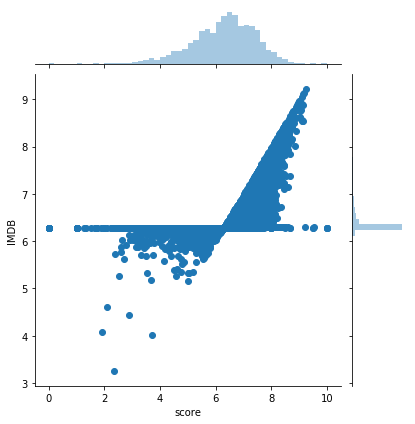

In [43]:
Topanimes = Bestanime(Anime,0.8,0,len(Anime)) 
b4=sns.jointplot(x='score', y='IMDB', data=Topanimes)

here, we can see IMDB= 7 divides the anime into two parts where the spread focuses and crosses at a value of 7 for IMDB. However, the score value that it switched from negative to positive is not straight across at 7 but rather is a sloped value starting at 4 when IMDB is 0 and ending at 9 when IMDB is 10. We consider the animes that have IMDB score greater than 7 are popular animes. 

    Here, I use 85th percentile to TOP 10 animes with IMDB score grader than 8.

In [36]:
Topanime = Bestanime(Anime,0.85,7,500) 
Topanime.head(10)

,anime_id,title,source,studio,genre,episodes,rating,score,scored_by,rank,popularity,producer,IMDB
2555,5114,Fullmetal Alchemist: Brotherhood,Manga,Bones,"Action, Military, Adventure, Comedy, Drama, Ma...",64,R - 17+ (violence & profanity),9.25,733592,1.0,4,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",9.197759
1028,32281,Kimi no Na wa.,Original,CoMix Wave Films,"Supernatural, Drama, Romance, School",1,PG-13 - Teens 13 or older,9.19,471398,2.0,33,"Kadokawa Shoten, Toho, Sound Team Don Juan, La...",9.111124
2999,9253,Steins;Gate,Visual novel,White Fox,"Thriller, Sci-Fi",24,PG-13 - Teens 13 or older,9.14,563857,5.0,8,"Frontier Works, Media Factory, Movic, AT-X, Ka...",9.074904
418,11061,Hunter x Hunter (2011),Manga,Madhouse,"Action, Adventure, Super Power, Shounen",148,PG-13 - Teens 13 or older,9.11,403377,8.0,35,"VAP, Nippon Television Network, Shueisha",9.020774
6572,28851,Koe no Katachi,Manga,Kyoto Animation,"Drama, School, Shounen",1,PG-13 - Teens 13 or older,9.04,296261,12.0,77,"Shochiku, Pony Canyon, Kodansha, ABC Animation...",8.922866
2783,4181,Clannad: After Story,Visual novel,Kyoto Animation,"Slice of Life, Comedy, Supernatural, Drama, Ro...",24,PG-13 - Teens 13 or older,9.01,363239,14.0,55,"Pony Canyon, TBS, Rakuonsha, Animation Do",8.914758
7403,2904,Code Geass: Hangyaku no Lelouch R2,Original,Sunrise,"Action, Military, Sci-Fi, Super Power, Drama, ...",25,R - 17+ (violence & profanity),8.95,543904,18.0,22,"Bandai Visual, Mainichi Broadcasting System, B...",8.887065
7105,199,Sen to Chihiro no Kamikakushi,Original,Studio Ghibli,"Adventure, Supernatural, Drama",1,PG - Children,8.92,498602,19.0,39,Toho,8.852266
11640,23273,Shigatsu wa Kimi no Uso,Manga,A-1 Pictures,"Drama, Music, Romance, School, Shounen",22,PG-13 - Teens 13 or older,8.88,413527,21.0,37,"Aniplex, Dentsu, Kodansha, Fuji TV, Kyoraku In...",8.799996
6511,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,Manga,Production I.G,"Comedy, Sports, Drama, School, Shounen",10,PG-13 - Teens 13 or older,8.99,157934,17.0,274,"TOHO animation, Shueisha",8.782021


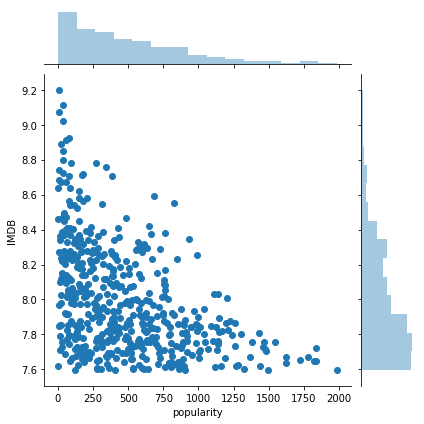

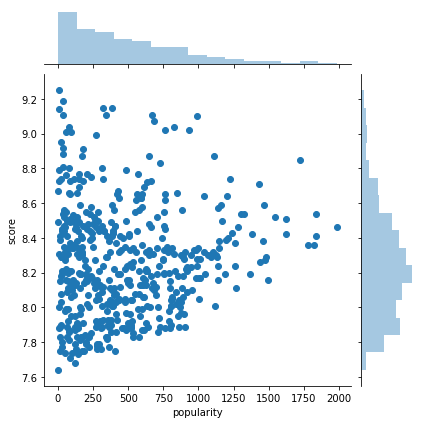

In [38]:
Fig_1=sns.jointplot(x='popularity', y='IMDB', data=Topanime)
Fig_2=sns.jointplot(x='popularity', y='score', data=Topanime)

As shown in Figures above, we also calculated the relation between IMDB and another anime feature called “popularity” which is a ranking where the lower the value is, the more popular the anime is.  The figures show that IMDB scores plotted against popularity provided a hyperbola like graph for the relationship. The regular score plotted against popularity results in just an unorganized mass of points that no meaningful interpretation can be had from and therefore not very useful. Comparing the two encouraged us to use the IMDB scores for our work.

###  Mode2：User-based Collaborative Filtering
Collaborative Filtering (CF) is a command method of recommendation based on users’ behavior. In this work I used User-Based Collaborative filtering.I built an m × n matrix U for user and their watched animes, where m is the number for all users, and n in the number of total animes. The element $u_{ij}$ in the matrix $U_{m\times n}$ means that user i has watched the anime j and gave their own individual score, I filled up element $u_{ij}$ by the user’s (i) score for this anime 
(j), otherwise I filled up the element as 0. The following table show the structure of the matrix. 


In [10]:
UserMatrix=pd.DataFrame(UserAnime.groupby('username')['my_score'].apply(list))
UserMatrix =UserMatrix["my_score"].apply(pd.Series)
UserMatrix = UserMatrix.fillna(0).reset_index()
UserMatrix['username']=UserMatrix['username'].apply(str)
print("The shape of User-Anime Matrix:",UserMatrix.shape)
UserMatrix.head(20)

The shape of User-Anime Matrix: (105402, 12975)


,username,0,1,2,3,4,5,6,7,8,...,12964,12965,12966,12967,12968,12969,12970,12971,12972,12973
0,----phoebelyn,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,---L-AND-AME-4EV,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--AnimeBoy--,0.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--Etsuko--,9.0,9.0,0.0,8.0,8.0,8.0,8.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--FallenAngel--,10.0,0.0,8.0,9.0,9.0,9.0,9.0,8.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,--Kin--,7.0,10.0,8.0,6.0,8.0,9.0,10.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,--N--,0.0,9.0,9.0,8.0,9.0,10.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,--PHOENIX--,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,--RIE--,0.0,6.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,--Sc--,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def SelectedUser(UserMatrix,Username):
    targetUser =  UserMatrix[UserMatrix["username"]==Username]
    UserMatrixbulider=UserMatrix[UserMatrix["username"]!=Username].reset_index(drop=True)
    distance= dict()
    for i in range(0,len(UserMatrixbulider)):
        dist = manhattan_distances(targetUser.iloc[:,1:], UserMatrixbulider.iloc[i:i+1,1:])
        distance.update({UserMatrixbulider.at[i,"username"]:dist[0][0]})
    SelectedUser =min(distance, key=distance.get)
    print("The user who is most samliar to input user is :", SelectedUser)
    selectedAnime = UserAnime[UserAnime["username"]==SelectedUser]
    Animelist = selectedAnime[selectedAnime["my_score"]>8.5]["anime_id"].values.tolist()
    LikedAnime = list(map(int, Animelist))
    LikedAnimeName=Anime[Anime['anime_id'].isin(LikedAnime)]
    return LikedAnimeName[:30]

Here, we randomly select a user and recommend anime for him 

In [12]:
Name=User['username'][25]
print("The input user is",Name)
print("The fllowing animes are recommended to",Name)
SelectedUser(UserMatrix,Name)

The input user is Tomoki-sama
The fllowing animes are recommended to Tomoki-sama
The user who is most samliar to input user is : Gid_Lucion


,anime_id,title,source,studio,genre,episodes,rating,score,scored_by,rank,popularity,producer
1,2104,Seto no Hanayome,Manga,Gonzo,"Comedy, Parody, Romance, School, Shounen",26,PG-13 - Teens 13 or older,7.89,91206,727.0,366,"TV Tokyo, AIC, Square Enix, Sotsu"
4,12365,Bakuman. 3rd Season,Manga,J.C.Staff,"Comedy, Drama, Romance, Shounen",25,PG-13 - Teens 13 or older,8.67,107767,50.0,426,"NHK, Shueisha"
13,14227,Tonari no Kaibutsu-kun,Manga,Brain&#039;s Base,"Slice of Life, Comedy, Romance, School, Shoujo",13,PG-13 - Teens 13 or older,7.71,281448,1093.0,88,"TV Tokyo, Aniplex, Nihon Ad Systems, Kodansha"
19,4224,Toradora!,Light novel,J.C.Staff,"Slice of Life, Comedy, Romance, School",25,PG-13 - Teens 13 or older,8.39,557898,174.0,13,"Genco, Starchild Records, Magic Capsule, Yomiu..."
20,10030,Bakuman. 2nd Season,Manga,J.C.Staff,"Comedy, Drama, Romance, Shounen",25,PG-13 - Teens 13 or older,8.49,122090,108.0,374,"NHK, Shueisha"
29,9863,SKET Dance,Manga,Tatsunoko Production,"Comedy, School, Shounen",77,PG-13 - Teens 13 or older,8.33,44132,213.0,646,"TV Tokyo, Avex Entertainment, Dentsu"
43,7674,Bakuman.,Manga,J.C.Staff,"Comedy, Drama, Romance, Shounen",25,PG-13 - Teens 13 or older,8.32,167429,216.0,172,"NHK, Shueisha"
99,7791,K-On!!,4-koma manga,Kyoto Animation,"Comedy, Music, School, Slice of Life",26,PG-13 - Teens 13 or older,8.14,178001,383.0,183,"Pony Canyon, TBS, Movic, Rakuonsha, Animation Do"
218,10521,Working&#039;!!,4-koma manga,A-1 Pictures,"Slice of Life, Comedy, Romance",13,PG-13 - Teens 13 or older,7.96,93040,609.0,516,"Aniplex, Yomiuri Telecasting, Rakuonsha"
297,15809,Hataraku Maou-sama!,Light novel,White Fox,"Comedy, Demons, Supernatural, Romance, Fantasy",13,PG-13 - Teens 13 or older,7.98,389033,578.0,51,"Sotsu, Lantis, Pony Canyon, Magic Capsule, Inf..."


###  Mode3：Genre-based Collaborative Filtering

    In this mode, we computed the similarity between Animes in item-based CF. In this work I used Jaccard similarity score. Let u_{i, k} denotes the similarity between anime i and anime k and v_{i, j} denotes the rating that user i gives to item j with v_{i, j} = ? if the user has not rated that item. Jaccard similarity can be expressed as the following:

J(A,B) = $\frac{|A\cap B|}{|A\cup B|} = \frac{|A\cap B|}{|A| + |B| - |A\cap B|}$

In [106]:
def Animegenre(file,animeId,threshold):
    genreDistribution = file[['anime_id']].join(file["genre"].str.get_dummies(', '))
    genreDistributionfiltered=genreDistribution[genreDistribution["anime_id"]!=animeId]
    Selected =pd.DataFrame()
    for i in range(0,len(genreDistributionfiltered)):
        score= jaccard_similarity_score(genreDistribution[genreDistribution["anime_id"]==animeId].iloc[:,1:],genreDistributionfiltered.iloc[i:i+1,1:])
        if score > threshold:
            Selected=pd.concat([Selected,genreDistributionfiltered.iloc[i:i+1,0:]],sort=False)
    animelist= list(Selected["anime_id"].values)
    AnimeSelected=Anime[Anime["anime_id"].isin(animelist)]
    return AnimeSelected

In [108]:
Animegenre(Anime,4224,0.8)

,anime_id,title,source,studio,genre,episodes,rating,score,scored_by,rank,popularity,producer
1561,24913,Bokura wa Minna Kawai-sou: Hajimete no,Manga,Brain&#039;s Base,"Slice of Life, Comedy, Romance, School",1,PG-13 - Teens 13 or older,7.74,15516,1012.0,2208,NaN
1871,8524,The Kabocha Wine: Nita no Aijou Monogatari,Unknown,Toei Animation,"Slice of Life, Comedy, Romance, School",1,PG-13 - Teens 13 or older,6.44,58,5858.0,10476,NaN
1901,11235,Amagami SS+ Plus,Visual novel,AIC,"Slice of Life, Comedy, Romance, School",13,PG-13 - Teens 13 or older,7.56,54248,1452.0,911,TBS
4802,8676,Amagami SS,Visual novel,AIC,"Slice of Life, Comedy, Romance, School",25,PG-13 - Teens 13 or older,7.51,94352,1600.0,372,"Pony Canyon, TBS, Movic"
5784,23701,Toradora! Recap,Unknown,J.C.Staff,"Slice of Life, Comedy, Romance, School",1,PG-13 - Teens 13 or older,7.67,17685,1178.0,1814,NaN
5983,3159,The Kabocha Wine,Manga,Toei Animation,"Slice of Life, Comedy, Romance, School",95,PG-13 - Teens 13 or older,6.87,169,4054.0,7715,NaN
9679,21405,Bokura wa Minna Kawai-sou,Manga,Brain&#039;s Base,"Slice of Life, Comedy, Romance, School",12,PG-13 - Teens 13 or older,7.83,114565,826.0,346,TBS
10345,21775,Yugami-kun ni wa Tomodachi ga Inai,Manga,A-1 Pictures,"Slice of Life, Comedy, Romance, School",2,PG-13 - Teens 13 or older,5.83,406,7748.0,7793,NaN
11220,1198,Tsuyokiss,Visual novel,"Trinet Entertainment, Studio Hibari","Comedy, Romance, School, Slice of Life",12,PG-13 - Teens 13 or older,6.68,6149,4865.0,3053,"Three Fat Samurai, Sol Blade"
11365,11553,Toradora!: Bentou no Gokui,Light novel,J.C.Staff,"Slice of Life, Comedy, Romance, School",1,PG-13 - Teens 13 or older,7.52,54343,1593.0,933,NaN


# Hybrid Recommendation Model

In [ ]:
def recommendation(animeId,user_index):

#   if there is no user and anime information, the system will recommendate the top 100 anime
    if animeId==None and user_index== None:
        Topanime = Bestanime(Anime,0.8,7,100) 
        return Topanime
#   if there the input only contains anime information, the system will recommendate anime that most samliar to input anime
    elif user_index==None:
        recommendatedAnime = Animegenre(Anime,animeId,0.8)
        return recommendatedAnime
#   if there the input only contains anime information, the system will recommendate anime that most samliar to input anime
    elif animeId==None:            
        SelectedUsername = SelectedUser(UserMatrix, User['username'][25])
        print("The user who are most samliar to input user:", SelectedUsername)
        selectedAnime = UserAnimefilter[UserAnimefilter["username"]==SelectedUsername]
        Animelist = selectedAnime[selectedAnime["my_score"]>8.5]["anime_id"].values.tolist()
        LikedAnime = list(map(int, Animelist))
        return LikedAnime
    else:
        recommendatedAnime = Animegenre(Anime,animeId,0.8)
        SelectedUsername = SelectedUser(UserAnimefilter,User,User["username"][user_index],user_index)
        selectedAnime = UserAnimefilter[UserAnimefilter["username"]==SelectedUsername]
        Animelist = selectedAnime[selectedAnime["my_score"]>8.5]["anime_id"].values.tolist()
        LikedAnime = list(map(int, Animelist))
        return set(recommendatedAnime).intersection(LikedAnime)
    
if __name__ == '__main__':
    recommendaed_AnimeList1 =recommendation(None,None)
    recommendaed_AnimeList2 =recommendation(None,466)
    recommendaed_AnimeList3 =recommendation(12189,None)
    recommendaed_AnimeList4 =recommendation(12189,466)
    print(recommendaed_AnimeList1) 
    print(recommendaed_AnimeList2)  
    print(recommendaed_AnimeList3)  
    print(recommendaed_AnimeList4)   

# Singular Value Decomposition
    In this work, We can see the UserMatrix is very sparse. A way to handle the sparsity issue is to leverage a latent factor model to capture the similarity between users and items. In this work, I decomposed the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items. (latent factors is a concept that a user or an anime have. For example, latent factor can refer to the genre that the anime belongs to)


![alt text][logo]

[logo]: https://wikimedia.org/api/rest_v1/media/math/render/svg/38aad41a3e44ded68732715012a793256eae76fe "Logo Title Text 2"

    SVD decreases the dimension of the UserMatrix matrix by extracting its latent factors. It helps us better understand the relationship between users and items as they become directly comparable. However,The main drawback of SVD is that there is no explanation to the reason why we recommend this item to an user. This is a huge problem if users are eager to know why a specific anime is recommended to them.